Chapter 03 평가
==

- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1스코어
- ROC AUC

01 정확도
--

> 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

In [22]:
# BaseEstimator 클래스를 상속받아 customized estimator 생성
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator): # 클래스...
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1)) #numpy array 헷갈
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [23]:
# 데이터 불러오기 및 가공
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('./train.csv')
y_df = df['Survived']
X_df = df.drop('Survived', axis=1)

##데이터 전처리  p.137##
from sklearn import preprocessing

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1] # 
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder() # LabelEncoder: 카테고리 피쳐를 0~의 숫자 값으로 변환. sklearn의 인코딩 API는 fit(), transform()으로 데이터 변환
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df
###########################

X_df = transform_features(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=0)

display(df.head(), X_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


In [26]:
# MyDummyClassifier 학습/예측/평가
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
predictions = myclf.predict(X_test)

print('정확도: {0:.4f}'.format(accuracy_score(y_test, predictions))) # format 형태??

정확도: 0.7877


> 단순한 알고리즘으로 예측을 해도 높은 정확도 수치

> 정확도를 평가 지표로 사용할 때는 매우 신중해야 함

> 특히 불균형한 레이블 값 분포 가진 데이터셋에서 부적합

In [35]:
# 불균형한 데이터 세트
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
#import numpy as np
#import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    def predict(self, X): # 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0으로 만들어서 반환
        return np.zeros((len(X),1), dtype=bool)
    
digits = load_digits()

# digits 번호가 7번이면 True, 이를 1로 변환, False는 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

display(y_test.shape[0], pd.Series(y_test).value_counts())

fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 해도 정확도는 {:.3f}'.format(accuracy_score(y_test, fakepred)))

450

0    405
1     45
dtype: int64

모든 예측을 0으로 해도 정확도는 0.900


> 정확도가 가지는 분류 평가 지표로서의 한계점 극복 위해 여러 가지 분류 지표와 함께 적용해야 함

02 오차 행렬
--

> 이진 분류에서 성능 지표로 활용

> 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지 함께 보여줌 (confusion matrix)

In [38]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred) # array 형태로 반환

array([[405,   0],
       [ 45,   0]], dtype=int64)

불균형 데이터는 positive/negative에 대한 예측 정확도가 다름

03 정밀도와 재현율
--

> 정밀도 Precision = TP / (FP + TP) ->  Negative를 Positive로 잘못 판단하면 안되는 경우 중요

> 재현율 Recall = TP / (FN + TP)  ->  Positive를 Negative로 잘못 판단하면 안되는 경우 중요

In [39]:
from sklearn.metrics import *

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [41]:
#from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('./train.csv')
y_df = df['Survived']
X_df = df.drop('Survived', axis=1)
X_df = transform_features(X_df)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=11) # 여기서 ran state 11로 한 이유가 있나?

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred  = lr_clf.predict(X_test)

get_clf_eval(y_test, pred)

[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


__정밀도-재현율 Trade-off__

> Threshold를 조정해 정밀도 또는 재현율 수치를 높일 수 있지만 두 지표는 트레이드오프 관계

In [51]:
# 예측 확률을 반환하는 pred_proba() 메서드
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 shape: {0}'.format(pred_proba.shape))
print(pred_proba[:3], '\n')

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중 더 큰 확률을 클래스 값으로 예측') # class 는 0, 1 순서
print(pred_proba_result[:3])

pred_proba() 결과 shape: (179, 2)
[[0.44935227 0.55064773]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]] 

두 개의 class 중 더 큰 확률을 클래스 값으로 예측
[[0.44935227 0.55064773 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [52]:
# threshold 조절해 성능 수치를 상호 보완적으로 조정하는 로직
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

binarizer = Binarizer(threshold=1.1) # threshold와 같거나 작으면 0, 크면 1 반환
binarizer.fit_transform(X)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [53]:
custom_threshold = 0.5

pred_proba1 = pred_proba[:,1].reshape(-1,1)

binarizer =  Binarizer(custom_threshold).fit(pred_proba1)
custom_predict = binarizer.transform(pred_proba1)

get_clf_eval(y_test, custom_predict)

[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [54]:
custom_threshold = 0.4

pred_proba1 = pred_proba[:,1].reshape(-1,1)

binarizer =  Binarizer(custom_threshold).fit(pred_proba1)
custom_predict = binarizer.transform(pred_proba1)

get_clf_eval(y_test, custom_predict)

[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


> 임계값 낮아지니 재현율 up 정밀도 down

In [60]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba1)

thr_index = np.arange(0, thresholds.shape[0], 15) # arange?
display(thresholds[thr_index], precisions[thr_index], recalls[thr_index])

array([0.11573101, 0.1317437 , 0.14927476, 0.17288741, 0.25749269,
       0.37571831, 0.49209939, 0.62876421, 0.75924585, 0.8961167 ])

array([0.37888199, 0.42446043, 0.45454545, 0.51886792, 0.61797753,
       0.67567568, 0.79661017, 0.93023256, 0.96428571, 1.        ])

array([1.        , 0.96721311, 0.90163934, 0.90163934, 0.90163934,
       0.81967213, 0.7704918 , 0.6557377 , 0.44262295, 0.21311475])

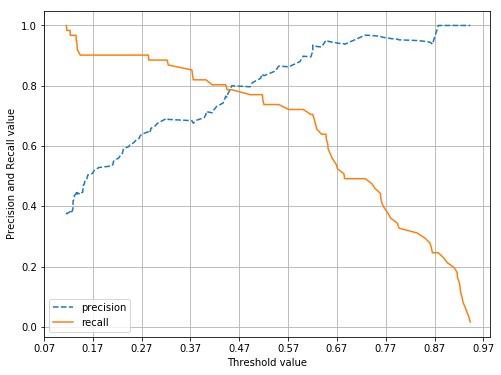

In [66]:
import matplotlib.pyplot as plt

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

04 F1 스코어
--

> F1 = 2 / (1/recall + 1/precision) = 2 x (precision x recall) / (precision+recall)

> 정밀도, 재현율이 한 쪽으로 치우치지 않을 때 높은 값을 가짐

In [61]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
f1

0.7966101694915254

05 ROC 곡선과 AUC
--

> 이진 분류 예측 성능 측정에서 중요하게 사용되는 지표

> Receiver Operation Characteristic Curve: FPR - TPR (재현율=민감도) (cf 특이성 specificity)

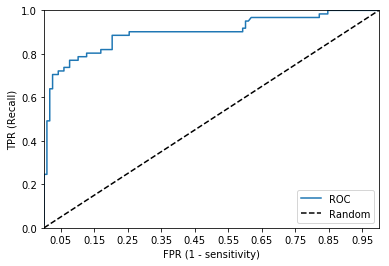

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random') # 가운데 대각선 직선
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR (1 - sensitivity)'); plt.ylabel('TPR (Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

> 가운데 직선에 가까울수록 성능이 떨어지고 멀어질수록 성능이 뛰어남

In [65]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8429


> 1에 가까울수록 좋은 수치, 가운데 대각선은 랜덤 수준으로 AUC값이 0.5